In [315]:
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import seaborn as sns 
import nltk as nlp
import string
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re

In [316]:
plt.rc("font",size = 15)
sns.set(style="dark")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
%matplotlib inline
pd.set_option('display.max_columns',500)

In [317]:
#import data 
train = pd.read_csv("train.txt", sep= '\s+', engine='python')
test = pd.read_csv("test.txt",  sep = 'delimiter', header=None,engine='python')
test.columns = ['text']

# Initial Analysis

## Assumptions and Observations: 
<br>
1) Dealing with blank lines; the empty text with no tags in the set was not imported. 

2) The training set had close to 60,000 observations after removing blank lines, while the test set had close to 24,000 observations after blank line removal 

4) Missing values: The training set had 5 missing text values, and no missing tags, while the test set had one missing text value.  

In [318]:
#quick analysis 
def quick_analysis(df): 
    print('Data Types: \n',df.dtypes)
    print('\nData Shape: \n',df.shape)
    print('\nOverall Info: \n', df.info())
    print('\nNull Values: \n', df.isna().sum())

## Data Information  

In [319]:
# training set 
quick_analysis(train)

Data Types: 
 text    object
tag     object
dtype: object

Data Shape: 
 (62730, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62730 entries, 0 to 62729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62725 non-null  object
 1   tag     62730 non-null  object
dtypes: object(2)
memory usage: 980.3+ KB

Overall Info: 
 None

Null Values: 
 text    5
tag     0
dtype: int64


In [320]:
#test set 
quick_analysis(test)

Data Types: 
 text    object
dtype: object

Data Shape: 
 (23394, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23394 entries, 0 to 23393
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23393 non-null  object
dtypes: object(1)
memory usage: 182.9+ KB

Overall Info: 
 None

Null Values: 
 text    1
dtype: int64


# Data Preprocessing: 
<br>
1) Since the test set only contained one missing record we dropped it 

2) The missing records in the training set were from the text feature and we had five such records, these missing text records were also dropped due to their quantity


In [321]:
#dropping missing records 
test.dropna(inplace = True)
train.dropna(inplace = True)

In [322]:
#number of unique tokens 
print("We Have {} unique words and {} unique tags.".format(train.text.nunique(),train.tag.nunique()))

We Have 14876 unique words and 13 unique tags.


# EDA 
<br>
1) We took a look at the number of observations of each of our tags. By far the most common tag is O (outside), following that was the B tag (beginning of the chunk) 

2) The most common token was found to be the person entity either occurring at the beginning or inside the chunk

In [323]:
# tag counts 
train.tag.value_counts()

O                  59565
B-person             660
B-location           548
I-person             335
B-group              264
I-location           245
B-corporation        221
I-creative-work      206
I-product            203
I-group              150
B-product            142
B-creative-work      140
I-corporation         46
Name: tag, dtype: int64

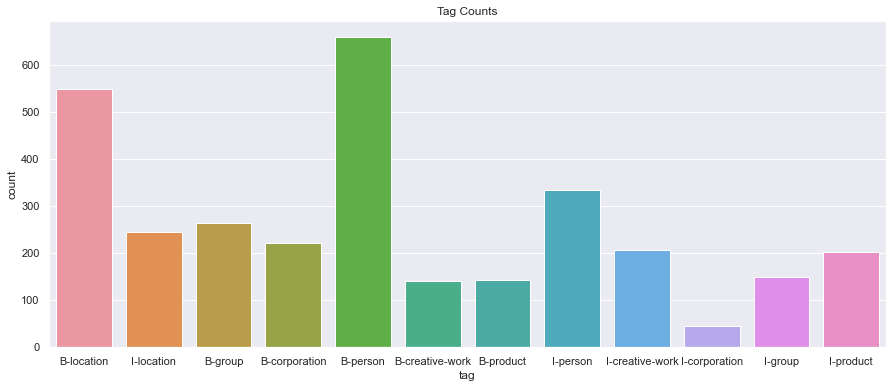

In [324]:
#visualizing tag counts 
plt.figure(figsize = (15,6))
sns.countplot(data= train[train.tag != 'O'], x= 'tag')
plt.title("Tag Counts")
plt.show()

# Feature Engineering: 
<br>

1) We removed some of the noise in our text as a preprocessing step. We didn't remove stop words because they would get the 'O' tag either way, we removed urls so that our classifier doesn't mistakingly classify without looking at the website, and finally we removed parentheses and square brackets. 

2) We used DictVectorizer from sklearn to transform the text features into feature indices. This is done so that we can pass our input to the chosen algorithms 

3) Our transformed training vector has about 15000 feature indices 



## Noise Removal

In [327]:
def noise_removal(text): 
    #remove urls 
    text = re.sub('http://','',text)
    #remove paranthesis 
    text = text.replace(')','').replace('(',"")
    #remove square brackets 
    text = text.replace(']','').replace('[','')
    return text 

train['text'] = train.text.apply(lambda x: noise_removal(x))
test['text'] = test.text.apply(lambda x: noise_removal(x))

## Feature Extraction

In [328]:
from sklearn.feature_extraction import DictVectorizer

In [329]:
#preparing the train
x = train.drop("tag",axis = 1)
v_train = DictVectorizer(sparse = False) 
x = v_train.fit_transform(x.to_dict('records'))



In [330]:
#after transformation
"The transformed training vector has {} feature indices."\
.format(x.shape[1])

'The transformed training vector has 14832 feature indices.'

# Modeling: 



## Summary, Results, and Question Solutions: 

### Modeling Strategy:
<br>
We used a multitude of classic multi-label classifiers to predict text tags, the models included linear classifiers in SGD and linear support vector machines under the assumption that a linear hyperplane with max margins could be found, Naive Bayes classifier due to its capability of generating likelihoods of a text belonging to a tag, and RandomForest due to its ensemble nature which aggregates the results of decorrelated models. 

<br>

### Prediction Results:

<br>


Each model was first evaluated based on a classification report where micro and macro averaging methods were used. The F1-score was the metric of choice as it allows us to gain a balance between precision and recall, our best F1-score came from the Perceptron and LinearSVC each with a micro-average of 0.33 and a macro-average of 0.26 with Naive Bayes being a close second.

<br>

Each model's performance and discriminative ability were found through subset accuracy and the Hamming loss. All models performed similarly with an accuracy near 95% and a loss close to 0.04. Our best performing model was Multinomial Naive Bayes with an accuracy of 95.8% and a loss of 0.042. LinearSVC was a close second which was expected due to its known prowess in text classification. 

<br>

### Metric Choices: 

<br>

Subset accuracy and the Hamming loss were chosen as metrics for the following reasons:

<br>


Since our problem is a multi-label classification problem, we must take into account that a prediction which contains a subset of the actual classes is better than one which contains none of them. 

<br>

The Exact Match Ratio gives us the percentage of matches that have all their labels correctly classified, this has the disadvantage of ignoring partially correct answers, but will be useful as a strict metric of our model's ability to correctly classify all the labels.  

<br>


To obtain a more accurate view of the performance of our classifier on a label-by-label basis we will also use the Hamming loss which is the fraction of labels that are incorrectly predicted (ie; fraction of wrong labels over total number of labels). 
    


## Importing models and splitting the data 

In [331]:
#imports 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss


In [332]:
# splitting data 
y = train.tag.values
classes = np.unique(y)
classes = classes.tolist()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state = 0) 

## Adjusting Classes: 
 
Since our most common class is O (outside), it will make our predictions better than they actually are and to adjust for that, I will remove it from our classes as we evaluate our models




In [333]:
new_class = classes.copy()
new_class.pop()
new_class

['B-corporation',
 'B-creative-work',
 'B-group',
 'B-location',
 'B-person',
 'B-product',
 'I-corporation',
 'I-creative-work',
 'I-group',
 'I-location',
 'I-person',
 'I-product']

## Fitting Our Classifiers

In [334]:
#Perceptron 
per = Perceptron(n_jobs= -1)
per.fit(x_train,y_train)

# SGD Linear Classifier 
sgd = SGDClassifier(n_jobs= -1 )
sgd.fit(x_train,y_train)

#SVC classifier 
svc = LinearSVC(random_state= 0)
svc.fit(x_train,y_train)

#Naive Bayes classifier for multinomial models
nb = MultinomialNB(alpha= 0.01)
nb.fit(x_train,y_train)

# RandomForest
rf = RandomForestClassifier(n_jobs =-1, n_estimators= 2,max_depth=6, random_state= 0) 
rf.fit(x_train,y_train)

#Passive Aggressive Classifier
pas = PassiveAggressiveClassifier()
pas.fit(x_train,y_train)



PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

## Predictions and Model Evaluation 

Here we predict on the data we held out for validation and use a classification report to check our model's predictive power 

For evaluating our model we will use the hamming loss and the exact match ratio (subset accuracy) 




In [335]:
# predictions
per_pred = per.predict(x_test)
sgd_pred= sgd.predict(x_test)
nb_pred = nb.predict(x_test)
svc_pred = svc.predict(x_test)
rf_pred = rf.predict(x_test)
pas_pred = pas.predict(x_test)



In [343]:
# Classification Reports 

models = ['Perceptron','SGD', 'NB', 'LinearSVC','RandomForest Classifier','Passive Aggressive Classifier']
preds = [per_pred, sgd_pred, nb_pred, svc_pred, rf_pred, pas_pred]

def class_report(models, preds): 

 

    print('Detailed Model Results: \n')
    for pred,model in zip(preds,models):

        print(f"{model} classification report: \n{classification_report(y_test,pred,zero_division=1,labels=new_class)}")
        print('\n')
        print(f"{model} Subset Accuracy: {accuracy_score(y_test,pred):.3%}\n")
        print(f"{model} Hamming Loss: {hamming_loss(y_test,pred, ):.3%}\n")
        print('\n')
        print('\n')

class_report(models,preds)

Detailed Model Results: 

Perceptron classification report: 
                 precision    recall  f1-score   support

  B-corporation       0.42      0.48      0.44        67
B-creative-work       0.11      0.03      0.04        40
        B-group       0.53      0.17      0.26        98
     B-location       0.80      0.29      0.43       174
       B-person       0.76      0.32      0.45       201
      B-product       1.00      0.24      0.39        37
  I-corporation       0.25      0.10      0.14        10
I-creative-work       0.32      0.16      0.21        56
        I-group       0.17      0.05      0.07        43
     I-location       0.29      0.12      0.17        76
       I-person       0.59      0.18      0.28        87
      I-product       0.41      0.14      0.21        50

      micro avg       0.55      0.23      0.33       939
      macro avg       0.47      0.19      0.26       939
   weighted avg       0.57      0.23      0.32       939



Perceptron Subset Accu

# Test Set Predictions 

We use our two best models; NB, and linearSVC for our test set predictions

In [344]:
#transform
test_arr = v_train.transform(test.to_dict('records'))

In [345]:
nb_test_pred = nb.predict(test_arr)
svc_test_pred = svc.predict(test_arr)

In [346]:
#appending predictions 
test['NB_predicitons'] = nb_test_pred
test['LinearSVC_predictions']= svc_test_pred

In [347]:
test

,text,NB_predicitons,LinearSVC_predictions
0,&,O,O
1,gt,O,O
2,;,O,O
3,*,O,O
4,The,O,O
...,...,...,...
23389,with,O,O
23390,this,O,O
23391,dress,O,O
23392,code,O,O


In [348]:
#output to csv 
test.to_csv("test_predictions.csv",index= False)

# Further Work: 

To improve our results, particularly our precision and recall (and hence our F-score), I would proceed as follows 

<br>

1) Get the full sentences which our tokens come from, this will allow us to identify the context the tokens are being used in, and would allow for better POS-tagging and feature engineering 



2) Utilize Bidirectional LSTM and recurrent neural networks to further improve our predictive power 